In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler
from dataset import kline_data, prepare_prediction_data
from models import rnn_lstm, rnn_gru

In [2]:
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
if not os.path.exists('plots'):
    os.mkdir('plots')

## Daily

In [3]:
btc = kline_data()
btc['d_oc_p'] = (btc['close'] - btc['open']) / btc['open']
btc.tail()

Last saved data candle close time: 2021-08-04 00:00:00


,open_time,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,d_oc_p
1443,2021-07-30 00:00:00,40018.49,42316.71,38313.23,42206.37,73602.784805,2021-07-31 00:00:00,2.939834e+09,1797012,37730.426862,1.509173e+09,0.0,0.054672
1444,2021-07-31 00:00:00,42206.36,42448.00,41000.15,41461.83,44849.791012,2021-08-01 00:00:00,1.868286e+09,1565380,22844.245050,9.518879e+08,0.0,-0.017640
1445,2021-08-01 00:00:00,41461.84,42599.00,39422.01,39845.44,53953.186326,2021-08-02 00:00:00,2.227567e+09,1603964,25796.753795,1.066580e+09,0.0,-0.038985
1446,2021-08-02 00:00:00,39850.27,40480.01,38690.00,39147.82,50837.351954,2021-08-03 00:00:00,2.010928e+09,1162878,24558.005343,9.715967e+08,0.0,-0.017627
1447,2021-08-03 00:00:00,39146.86,39780.00,37642.03,38207.05,57117.435853,2021-08-04 00:00:00,2.195361e+09,1379871,27683.466598,1.064119e+09,0.0,-0.024007


In [4]:
data = np.array(btc['d_oc_p'])
minmax = MinMaxScaler()
data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(data, axis=-1)))
data_norm.shape

(1448,)

In [5]:
input_size = 20
x, y = prepare_prediction_data(data_norm, input_size=input_size)
n_samples = x.shape[0]
x.shape, y.shape

((1328, 120), (1328,))

In [6]:
x_train = np.expand_dims(x[:int(n_samples * 0.85), :], axis=-1)
x_test = np.expand_dims(x[int(n_samples * 0.85):, :], axis=-1)
y_train = y[:int(n_samples * 0.85)]
y_test = y[int(n_samples * 0.85):]

In [7]:
model = rnn_gru(input_size=input_size)
ea = EarlyStopping(patience=20)
cp = ModelCheckpoint('saved_models/gru_d_oc_p_1d.h5')
cb = [ea, cp]
history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)

Epoch 1/100
25/25 [==============================] - 4s 64ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 2/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 3/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 4/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 6/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 7/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 8/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 10/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0043 - val_loss: 0.0045

25/25 [==============================] - 3s 127ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 82/100
25/25 [==============================] - 3s 115ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 83/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 84/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 85/100
25/25 [==============================] - 3s 128ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 86/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 87/100
25/25 [==============================] - 3s 128ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 88/100
25/25 [==============================] - 3s 125ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 89/100
25/25 [==============================] - 3s 118ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 90/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0043 - val_loss: 

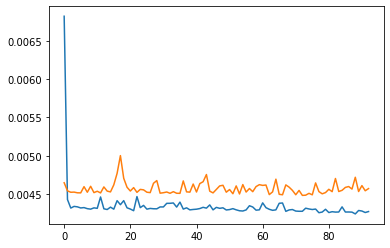

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [9]:
print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')

Test set MSE: 0.005380347836762667


In [10]:
y_test_pred = np.squeeze(model.predict(x_test))
test_open_prices = np.array(btc['open'])[-y_test.shape[0]:]
test_close_prices = np.array(btc['close'])[-y_test.shape[0]:]

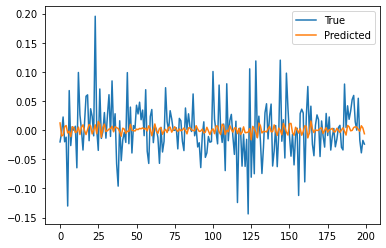

In [42]:
plt.plot(np.squeeze(minmax.inverse_transform(np.expand_dims(y_test, axis=-1))), label='True')
plt.plot(np.squeeze(minmax.inverse_transform(np.expand_dims(y_test_pred, axis=-1))), label='Predicted')
plt.legend()

According to this, the best price prediction for tomorrow is today's price

In [11]:
d_oc_p_test = np.squeeze(minmax.inverse_transform(np.expand_dims(y_test_pred, axis=-1)))
d_oc_test = d_oc_p_test * test_open_prices

In [12]:
test_close_prices_pred = test_open_prices + d_oc_test

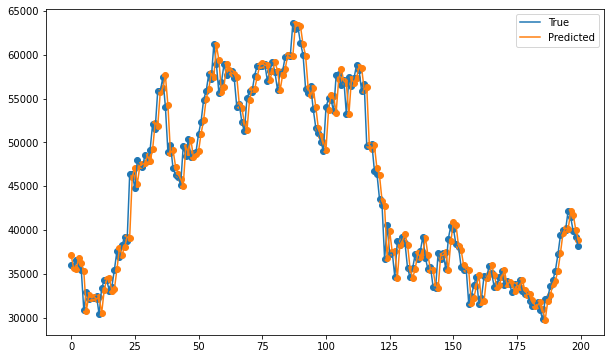

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(test_close_prices, label='True')
plt.plot(test_close_prices_pred, label='Predicted')
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices)
plt.scatter(np.arange(test_close_prices.shape[0]), test_close_prices_pred)
plt.legend()

## 4H

In [56]:
btc = kline_data(interval='4h')
btc['d_oc_p'] = (btc['close'] - btc['open']) / btc['open']
btc.tail()

Last saved data candle close time: 2021-08-04 12:00:00


,open_time,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,d_oc_p
8668,2021-08-03 16:00:00,38169.45,38550.24,37642.03,38011.37,9155.330268,2021-08-03 20:00:00,3.490941e+08,233408,4490.572035,1.712726e+08,0.0,-0.004142
8669,2021-08-03 20:00:00,38008.80,38643.00,37870.00,38207.05,6071.641188,2021-08-04 00:00:00,2.323112e+08,183239,3028.634356,1.158985e+08,0.0,0.005216
8670,2021-08-04 00:00:00,38207.04,38566.82,37890.54,37976.81,5603.620628,2021-08-04 04:00:00,2.141602e+08,128941,2768.159669,1.057951e+08,0.0,-0.006026
8671,2021-08-04 04:00:00,37976.82,38213.99,37674.18,37828.84,7233.662046,2021-08-04 08:00:00,2.741890e+08,133188,3851.288012,1.459639e+08,0.0,-0.003897
8672,2021-08-04 08:00:00,37828.84,38260.00,37508.56,38160.06,7663.712387,2021-08-04 12:00:00,2.903733e+08,147037,3913.443493,1.483031e+08,0.0,0.008756


In [59]:
data = np.array(btc['d_oc_p'])[-1500:]
minmax = MinMaxScaler()
data_norm = np.squeeze(minmax.fit_transform(np.expand_dims(data, axis=-1)))
data_norm.shape

(1500,)

In [60]:
input_size = 20
x, y = prepare_prediction_data(data_norm, input_size=input_size)
n_samples = x.shape[0]
x.shape, y.shape

((1480, 20), (1480,))

In [61]:
x_train = np.expand_dims(x[:int(n_samples * 0.85), :], axis=-1)
x_test = np.expand_dims(x[int(n_samples * 0.85):, :], axis=-1)
y_train = y[:int(n_samples * 0.85)]
y_test = y[int(n_samples * 0.85):]

In [62]:
model = rnn_gru(input_size=input_size)
ea = EarlyStopping(patience=20)
cp = ModelCheckpoint('saved_models/gru_d_oc_p_4h.h5')
cb = [ea, cp]
history = model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=cb, validation_split=0.3)

Epoch 1/100
28/28 [==============================] - 5s 42ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 4/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0083
Epoch 8/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 9/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0065 - val_loss: 0.0089
Epoch 10/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0084

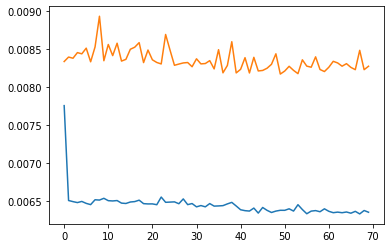

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [64]:
print(f'Test set MSE: {model.evaluate(x_test, y_test, verbose=0)}')

Test set MSE: 0.003533880226314068


In [65]:
y_test_pred = np.squeeze(model.predict(x_test))
test_open_prices = np.array(btc['open'])[-y_test.shape[0]:]
test_close_prices = np.array(btc['close'])[-y_test.shape[0]:]

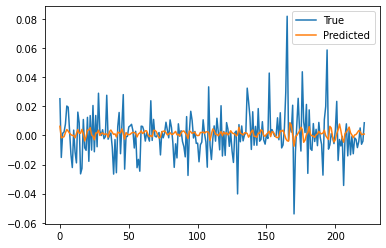

In [66]:
plt.plot(np.squeeze(minmax.inverse_transform(np.expand_dims(y_test, axis=-1))), label='True')
plt.plot(np.squeeze(minmax.inverse_transform(np.expand_dims(y_test_pred, axis=-1))), label='Predicted')
plt.legend()

In [67]:
d_oc_p_test = np.squeeze(minmax.inverse_transform(np.expand_dims(y_test_pred, axis=-1)))
d_oc_test = d_oc_p_test * test_open_prices

In [68]:
test_close_prices_pred = test_open_prices + d_oc_test

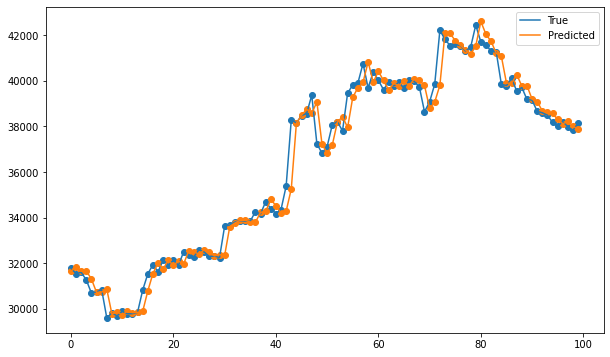

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(test_close_prices[-100:], label='True')
plt.plot(test_close_prices_pred[-100:], label='Predicted')
plt.scatter(np.arange(100), test_close_prices[-100:])
plt.scatter(np.arange(100), test_close_prices_pred[-100:])
plt.legend()